In [2]:
%run ../aux_funcs.py
%run ../RSRG.py
%run ../RSRG_class.py
#from iminuit import cost, Minuit

In [3]:
def linear_fit(x, m, b):
    return m*x+b

In [ ]:
L = 40
steps = 1400
measure_step = 10

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)

J_ij_vals, h_vals, R0_array, mu_array = run_decimation(L, steps, measure_step, a_vals, b_vals, track_moments=True)

In [ ]:
x = L*L - np.arange(len(R0_array))*measure_step
y = 1/np.array(R0_array)
R_length = len(y)

plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[int(R_length/2):], y[int(R_length/2):])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
#plt.ylim(0, 1.5)

In [ ]:
x = np.log(L*L - np.arange(len(R0_array))*measure_step)
y = np.log(mu_array)
R_length = len(y)

plt.scatter(x, y, label='Average moments')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(linear_fit, x[int(R_length/100):], y[int(R_length/100):])
print(popt)

plt.title("Scaling of Cluster moments")
plt.xlabel("Log Remaining Spins (N)")
plt.ylabel(r"Log $(\mu)$")
plt.plot(x, linear_fit(x, *popt), color='red', label=r'Linear Fit')

plt.gca().invert_xaxis()
plt.legend()

#plt.ylim(0, 1.5)

In [4]:
#TEST!!!! CLEAN UP LATER

def fill_J_ij_matrix_uniform(size, nn_ind, J_max, include_nnn=False):
    J_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        #Filling nn bonds
        adj_ind_array = np.array(nn_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.random.uniform(0, J_max, size=len(upper_ind)))
        
        if include_nnn:
            #Filling nnn bonds
            w = (np.sqrt((a/3)**2 + 2*(b/3)) - a/3)/(b/3)
            adj_ind_array = np.array(nnn_ind[ind])
            upper_ind = adj_ind_array[adj_ind_array>ind]

            J_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.exp(-np.array(random_nnnDist(w, a/6.0, b/6.0, custDist=linDist, size=len(upper_ind)))))

    return J_ij_vals + J_ij_vals.T

h_vals = np.exp(-np.random.exponential(size=L*L))

def fill_h_array_uniform(size, h_max):
    return np.random.uniform(0, h_max, size=size)

def extract_width(hs, Om):
    h_left = hs[hs!=0]
    c = cost.UnbinnedNLL(-np.log(h_left/Om), exponential_dist_norm)
    m = Minuit(c, a=0.8)
    m.migrad()
    return m.values[0]


#Generate list of equidistant points on log scaled axes for given system size and decimation steps
def gen_check_list(size, steps, divs):
    i_vals = np.arange(divs)
    C = np.log(size/(size-steps))/(divs-1)
    return np.floor(size*np.exp(-i_vals * C)).astype(int)

In [14]:
L = 20
steps = int(0.99*L*L)
a, b = 0.3, 0.3
measure_step = 30

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

measure_list = np.floor(steps*(1/(1.1**np.arange(1,60))))
measure_list = measure_list.astype(int)
check_list = np.floor(L*L*(1- 1/(3**np.arange(4))))  #Indices at which the distribution of couplings is measured

runs = 1


check_list = gen_check_list(L*L, steps, 10)
measure_list = gen_check_list(L*L, steps, 50)

In [15]:
J_dist_list = [np.array([]) for i in range(10)]
h_dist_list = [np.array([]) for i in range(10)]


In [16]:
a_vals = np.array([0.3])
b_vals = np.array([0.3])

J_max, h_max = 1.0, 0.5

a_list = np.zeros(shape=(len(a_vals), len(measure_list)))
b_list = np.zeros(shape=(len(b_vals), len(measure_list)))
R0_array = np.zeros(shape=(len(a_vals), len(measure_list)))

n_bins_h = 60
h_dist_sum = np.zeros(shape=(len(check_list), n_bins_h))  #Array to average the distribution of field couplings over runs
J_dist_sum = np.zeros(shape=(len(check_list), n_bins_h))

n_bins_J = 60
J_bin_list = []

for run in range(runs): 
    check_list_acc = 0
    #if True:
    for a_ind, a in enumerate(a_vals):
    #for b_ind, b in enumerate(b_vals):
        J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b, include_nnn=False)
        h_vals = np.exp(-np.random.exponential(size=L*L))
        
        #J_ij_vals = fill_J_ij_matrix_uniform(L*L, nn_ind, J_max)
        #h_vals = fill_h_array_uniform(L*L, h_max)
        
        test = system(L*L, adj_ind, J_ij_vals, h_vals)   

        for i in range(steps+1):
            if (L*L-i) in measure_list:
                ind = np.where(measure_list==(L*L-i))
                R0_array[a_ind, ind] += extract_width(test.h_vals, test.Omega)
                #print(R0_array)
                #R0_array[b_ind, ind] += m.values[0]
                #print(i)
                """
                if i in check_list:
                    h_remain = test.h_vals
                    h_remain = h_remain[h_remain!=0]
                    n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = 60)
                    width = bins[1]-bins[0]

                    popt, pcov = curve_fit(exponential_dist_norm, (bins[1:]-width/2)[:20], n[:20])
                    plt.scatter(bins[1:]-width/2, n, label="N="+str(L*L - i), s=10)
                    plt.plot(bins[1:]-width/2, exponential_dist_norm(bins[1:]-width/2, *popt))
                """
            if i in check_list:
                #a_sc = a/9
                #b_sc = b/9
                #print(i)
                h_remain = test.h_vals
                h_remain = h_remain[h_remain!=0]
                h_dist_list[check_list_acc] = np.concatenate((h_dist_list[check_list_acc],-np.log(h_remain/test.Omega)))
                #x = np.linspace(0, (np.sqrt(a_sc**2 + 2*b_sc) - a_sc)/b_sc, len(J_remain))

                #n,bins,patches = plt.hist(J_remain, density = 'True', bins=30)
                n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = n_bins_h, range=(0,6))
                
                width = bins[1]-bins[0]
                #popt, pcov = curve_fit(linDist, (bins[1:]-width/2), n)
                #a_list[a_ind, np.where(check_list==i)[0][0]] = popt[0]
                #plt.scatter((bins[1:]-width/2), n, label="N="+str(L*L-i))
                
                h_dist_sum[check_list_acc, :] += n
                
                J_remain = -np.log(sparse.find(test.J_ij_vals)[2]) + np.log(test.Omega)
                n_J,bins_J = np.histogram(J_remain, density = True, bins = n_bins_J)
                
                J_dist_sum[check_list_acc, :] += n_J
                if run==runs-1: J_bin_list.append(bins_J*extract_width(test.h_vals, test.Omega))
                
                check_list_acc+=1
            test.decimate()
                


/home/guaravtenkila/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/guaravtenkila/.local/lib/python3.8/site-packages/iminuit/cost.py:75: RuntimeWarning: invalid value encountered in log
  return np.log(x + 1e-323)


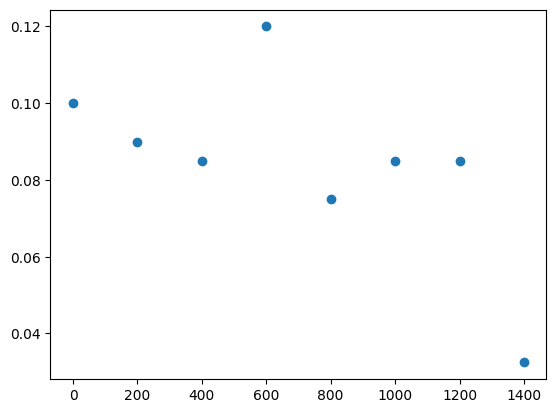

In [141]:
averaged_dec_ratio = []
average_step = 200
coupling_dec_list = np.array(test.coupling_dec_list)


for i in range(0, len(test.Gamma_array), average_step):
    averaged_dec_ratio.append(coupling_dec_list[i:i+average_step].mean())
    
plt.scatter(range(0, len(test.Gamma_array), average_step), averaged_dec_ratio)

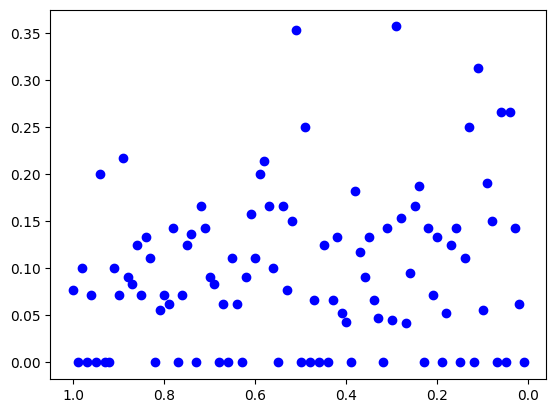

In [159]:

window_size = 100
average_kernel = 1.0 - np.arange(0.0, 1.0, 1/window_size)

dec_steps = L*L - np.arange(steps+1)
coupling_dec_list = np.array(test.coupling_dec_list)
Omega_array = np.exp(-np.array(test.Gamma_array))*test.Omega_0

#plt.scatter(dec_steps, test.Gamma_array)
plt.gca().invert_xaxis()

for i, cutoff in enumerate(average_kernel):
    if i==window_size-1: cutoff_mask = np.where(Omega_array<=cutoff)
    else: cutoff_mask = np.all([Omega_array<=cutoff, Omega_array>average_kernel[i+1]], axis=0)
    plt.scatter(cutoff, coupling_dec_list[cutoff_mask].mean(), c='blue')

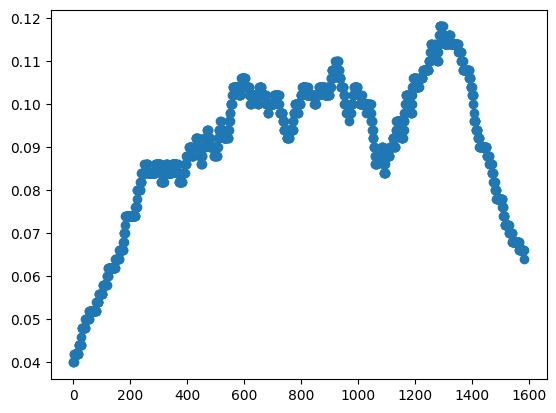

In [161]:
window_size = 500

mask = np.ones(window_size)/window_size
convolved_data=np.convolve(coupling_dec_list,mask,'same')

plt.plot(convolved_data, linestyle='', marker='o')


(0.1, 1)

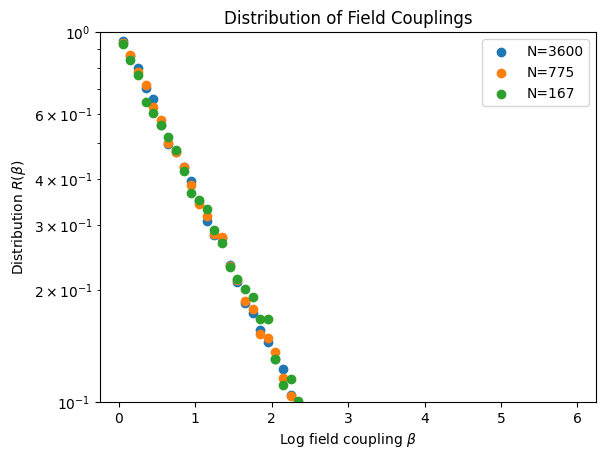

In [60]:


for ind,i in enumerate(check_list[:-1]):
    plt.scatter((bins[1:]-width/2), h_dist_sum[ind,:]/runs, label="N="+str(i))
#plt.xscale('log')

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
#plt.xlim(0.01, 4)
plt.legend()
#plt.ylim(0.01, 1)

#J_max, h_max = 1.0, 0.5
#L = 60
#a, b = 0.3, 0.315

plt.ylim(0.1,1)

Text(0.5, 1.0, 'Distribution of Bond Couplings')

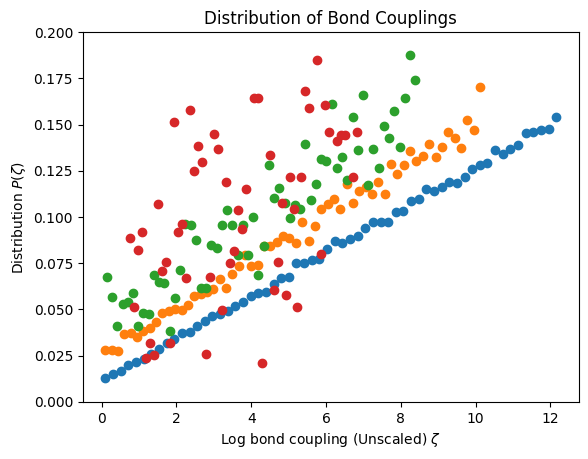

In [99]:


for ind,i in enumerate(check_list):
    bins_J = J_bin_list[ind]
    width_J = bins_J[1]-bins_J[0]
    plt.scatter((bins_J[1:]-width_J/2), J_dist_sum[ind,:]/runs, label="N="+str(L*L-i))
    
plt.ylim(0, 0.2)
plt.xlabel(r"Log bond coupling (Unscaled) $\zeta$")
plt.ylabel(r"Distribution $P(\zeta)$")
plt.title("Distribution of Bond Couplings")

In [21]:
x = check_list#L*L - np.arange(1+int(steps/measure_step))*measure_step
for b_ind, b in enumerate(b_vals):
    y = b_list[b_ind,:]*9/R0_array[b_ind,:]
    plt.plot(x, y, marker='o', label="("+str(a)+","+str(b)+")")
plt.gca().invert_xaxis()
plt.xscale('log')
plt.ylim(-0.2, 0.5)

plt.title("RG Flow of Bond Couplings")
plt.xlabel("Remaining Spins")
plt.ylabel(r" Scaled slope parameter $P(0)/R_0$")

plt.legend()

ValueError: operands could not be broadcast together with shapes (83,) (10,) 

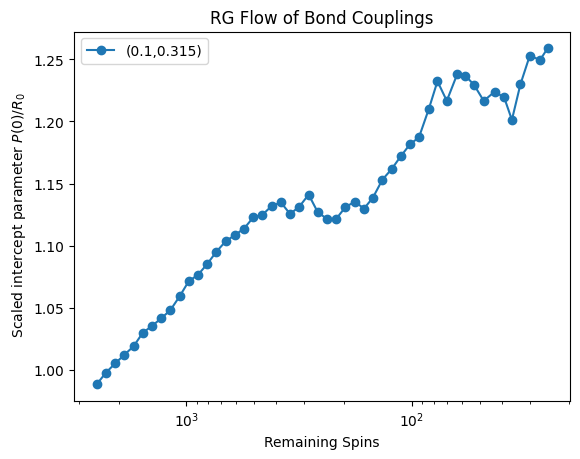

In [40]:
x = measure_list#L*L - np.arange(1+int(steps/measure_step))*measure_step
for a_ind, a in enumerate(a_vals):
    y = runs/R0_array[a_ind,:]
    plt.plot(x, y, marker='o', label="("+str(a)+","+str(b)+")")
plt.gca().invert_xaxis()
plt.xscale('log')
#plt.ylim(-0.2, 0.5)

plt.title("RG Flow of Bond Couplings")
plt.xlabel("Remaining Spins")
plt.ylabel(r" Scaled intercept parameter $P(0)/R_0$")

plt.legend()

/home/jebediah/Ising_RSRG/aux_funcs.py:96: RuntimeWarning: overflow encountered in power
  return scale*x**(-a)


[0.17845671 4.25567079]
0.35691342250725533


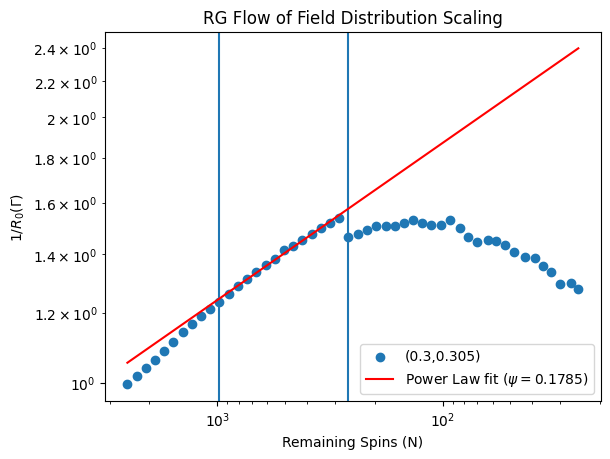

In [59]:
#x = L*L - np.arange(1+int(steps/measure_step))*measure_step

R_length = len(y)

start = 10
end = 24

plt.axvline(x = x[start])
plt.axvline(x = x[end])

for a_ind, a in enumerate(a_vals):
    y = runs/R0_array[a_ind,:]
    plt.scatter(x, y, label="("+str(a)+","+str(b)+")")#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)


#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)

In [18]:
L = 40
steps = int(0.95*L*L)
a, b = 0.1, 0.105
measure_step = 1

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

measure_list = np.floor(steps*(1/(1.1**np.arange(1,60))))
measure_list = measure_list.astype(int)
check_list = np.floor(L*L*(1- 1/(1.6**np.arange(10))))

runs = 1
import time

In [19]:
a_vals = np.array([0.1])
b_vals = np.array([0.105])

a_list = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))
b_list = np.zeros(shape=(len(b_vals), 1+int(steps/measure_step)))
R0_array = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))

t0 = time.time()
for run in range(runs):  
    for a_ind, a in enumerate(a_vals):
    #for b_ind, b in enumerate(b_vals):
        J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
        h_vals = np.exp(-np.random.exponential(size=L*L))
        test = system(L*L, adj_ind, J_ij_vals, h_vals)   

        for i in range(steps):
            test.decimate()
            if i%measure_step==0:  #(L*L-i) in measure_list:#
                ind = int(i/measure_step)#np.where(measure_list==(L*L-i))
                R0_array[a_ind, ind] += test.extract_width()
                
                
print(time.time()-t0)

30.315779209136963


In [28]:
len(test.R0_array)

76

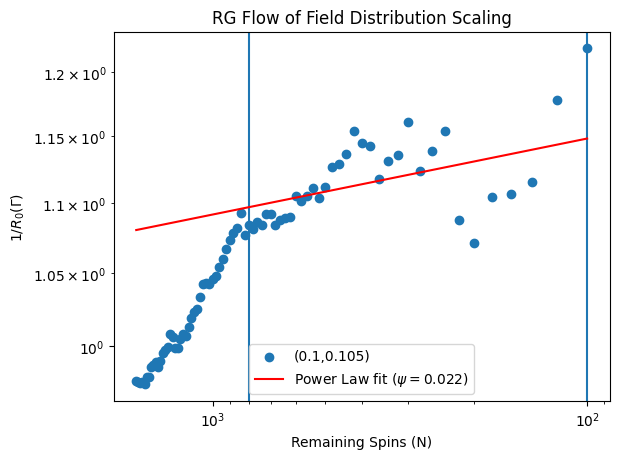

In [29]:
measure_step = 20
x = L*L - np.arange(int(steps/measure_step))*measure_step

#R_length = len(y)

start = 40
end = -1

plt.axvline(x = x[start])
plt.axvline(x = x[end])

for a_ind, a in enumerate(a_vals):
    y = runs/  np.array(test.R0_array)#R0_array[a_ind,:]
    plt.scatter(x, y, label="("+str(a)+","+str(b)+")")#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)


#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])


plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)

In [ ]:
def extract_width(hs, Om):
    h_left = hs[hs!=0]
    c = cost.UnbinnedNLL(-np.log(h_left/Om), exponential_dist_norm)
    m = Minuit(c, a=0.8)
    m.migrad()
    return m.values[0]